In [1]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/notebooks


In [2]:
%autoreload 2
import os
import networkx as nx
from rwtools.nemesis.graph.nemesis_node import NemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from rwtools.nemesis.graph.nemesis_node import NemesisNode

from rwtools.nemesis.graph.nemesis_node import NemesisNode
from rwtools.nemesis.graph.balance import balance_node_latencies

from rwtools.nemesis.graph.balance import * 


def to_png(graph, name="temp"):
    out_file = os.path.abspath(f"./{name}.dot")
    nx.drawing.nx_agraph.write_dot(graph, out_file)
    cmd = f"dot -Tpng {out_file} -o {name}.png"
    os.system(cmd)
    img = mpimg.imread(f"{name}.png")
    plt.figure(figsize = (10,10))
    plt.imshow(img)



## Optional code sequences 
The problem that needs solving is what I call 'optional code'. Pieces of code that are only executed if some condition holds, but that does not create an actual split in the code. In the control flow graph this is recognized as a node that is reachable via two paths, one that is longer than the other (more nodes in between)

The algorithm defined (at the time of writing) works for trees (where each node is reachable via 1 path only) but not for this type. The problem, concretely, is that adding the the longer path will also cause nodes to be added to the final node in the shorter path, which then introduces another imbalance



Unbalanced version 
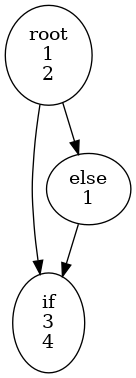 

balanced (without taking into account that graph is not actually a tree) 
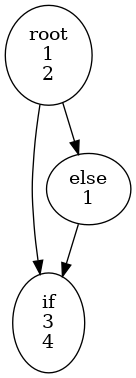

A very simple piece of code that generates this kind of structure 
```
int main(){
        int x = 20; 
        if (x == 10){
                x += 1; 
        }
        return 0; 
}

```
And the corresonding control flow 
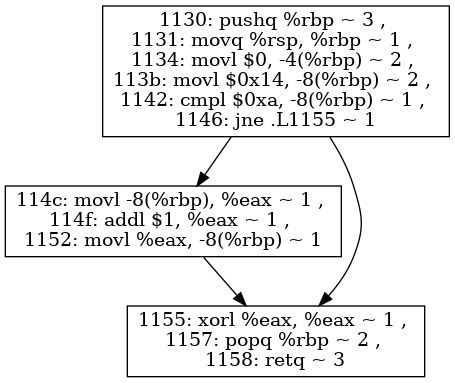

## approach 1 
Turn the graph into a tree that lets you easily balance it  
(1) convert graph into tree (keeping track of structure somehow)   
(2) balance tree (with existing algorithm)   
(3) convert back to original structure   

What do we need from original structure -- the leafs that are copied over from eachother  

**Remark** the original structure doesn't neccessarily have to be preserved as long as the semantics are the same -- step 3 is maybe not even neccessary 

**Question** How does this work when the optional section is embedded in a larger tree? In that case converting back to the original structure might be required 


From NetworkX documentation 


**undirected forest**  
An undirected graph with no undirected cycles.

**undirected tree**  
A connected, undirected forest.

**directed forest**  
A directed graph with no undirected cycles. Equivalently, the underlying graph structure (which ignores edge orientations) is an undirected forest. In convention B, this is known as a polyforest.

**directed tree**  
A weakly connected, directed forest. Equivalently, the underlying graph structure (which ignores edge orientations) is an undirected tree. In convention B, this is known as a polytree.

**branching**  
A directed forest with each node having, at most, one parent. So the maximum in-degree is equal to 1. In convention B, this is known as a forest.

**arborescence**  
A directed tree with each node having, at most, one parent. So the maximum in-degree is equal to 1. In convention B, this is known as a tree.

What we want is an arborescence (I think?) 

## Constructing an arborescence 
Assign to each edge a weight equal to it's depth (how many nodes have passed) multiplied with the total number of edges. This way the spanning tree algorithm will always favor longer paths 


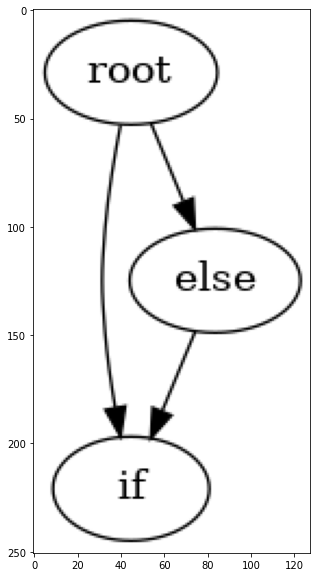

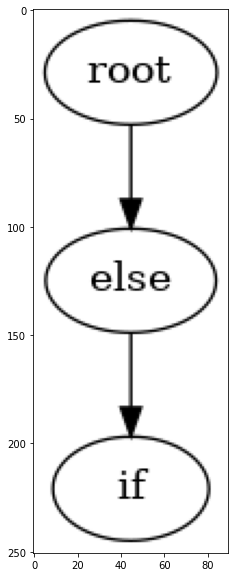

In [24]:

from networkx.algorithms.tree.recognition import *
from networkx.algorithms.tree import  minimum_spanning_arborescence, maximum_spanning_arborescence

root = NemesisNode([1,2], "root")
ifbranch = NemesisNode([3,4], "if")
elsebranch = NemesisNode([1], "else")

def assign_edge_weights(graph,node, depth): 
    successors = list(graph.successors(node)) 
    for s in successors: 
         # is het nodig om hier te mul met number of edges? 
        graph[node][s]['weight'] = depth*graph.number_of_edges() 
    for s in successors: 
        assign_edge_weights(graph, s, depth+1)
        
def unwind_graph(graph): 
    max_G = maximum_spanning_arborescence(graph) 
    return max_G 



G = nx.DiGraph()
G.add_nodes_from([root, ifbranch, elsebranch])
G.add_edges_from([(root, ifbranch), (root, elsebranch), (elsebranch, ifbranch)])

to_png(G, "optional_code")


# assign edge weights so that maximum spanning graph corresponds to what we want
assign_edge_weights(G, root, 1)  

# 'unwind' graph to get a tree
max_G = unwind_graph(G)
to_png(max_G)

# copy over the part the 'optional code' as the branch that was just now deleted 

